# vine copula (vinecop)

- Fitting

> obs -> edge -> tree -> bcp -> (next lv) obs

The function `VineCop.fit` takes multivariate copula observations (of shape $(n,D)$ and values inside $(0,1)$). By default at each level, it proposes potential edges between (pseudo)observations under proximity conditions, calculates corresponding bivariate dependency metrics to determine bicops-to-fit using modified Kruskal's maximum spanning tree (MST, Dissmann 2013), then fit bicops and calculates pseudo-obs for the next level using their `hfunc`.

This function can make `VineCop` following c/d/r-vine restrictions using Dissmann algo, and can use existing structure matrix to make `VineCop`.

This function can prioritize vertices inside `first_tree_vertex` such that the fitted vine can be used to conduct **conditional simulation**.

- Simulation (inverse Rosenblatt transform)

The `sample_order` attribute inside a `VineCop` object shows sequentially (from right to left, from shallowest to deepest) `D` pseudo-observation (on `D` levels) as source vertices to walk `D` paths until their corresponding `D` target vertices on the top level. Along each path, iteratively we do `hinv` from lower vertex to upper vertex, but may (recursively) request `hfunc` if its opposite upper vertex is not available.

With `first_tree_vertex` given during fitting, the fitted `VineCop` object allows for **conditional simulation**, where `dct_v_s_obs` and `sample_order` can be specified for `.sample()`.


In [1]:
import sys
import platform
import math
import torch
from torch.special import ndtr, ndtri
import torchvinecopulib as tvc
from torchvinecopulib.util import _EPS

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = "cpu"
print("Python:", sys.version.replace("\n", " "))
print("Platform:", platform.platform())
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
torch.random.manual_seed(42)
num_dim = 6
rho = 0.95
V = torch.randn(size=(10000, 2), dtype=torch.float64)
V[:, 1] = rho * V[:, 0] + math.sqrt(1 - rho**2) * V[:, 1]
VV = torch.randn(size=(5000, 2), dtype=torch.float64)
VV[:, 1] = -rho * VV[:, 0] + math.sqrt(1 - rho**2) * VV[:, 1]
V = ndtr(torch.vstack([V, VV])).clamp(_EPS, 1 - _EPS)
obs_mvcp = V
for _ in range(1 + num_dim // 2):
    idx = torch.randperm(obs_mvcp.shape[0])
    obs_mvcp = torch.hstack(
        [
            obs_mvcp,
            torch.hstack(
                [
                    torch.vstack(
                        [
                            obs_mvcp[torch.randperm(1000), [0]].reshape(-1, 1),
                            obs_mvcp[idx[1000:], [0]].reshape(-1, 1),
                        ]
                    ),
                    obs_mvcp[idx, [1]].reshape(-1, 1),
                ]
            ),
        ]
    )
obs_mvcp = obs_mvcp[torch.randperm(obs_mvcp.shape[0])[:10000], :num_dim].to(DEVICE)
obs = ndtri(obs_mvcp)
# obs = obs_mvcp
is_cop_scale = False
del V, VV, obs_mvcp, rho

Python: 3.13.3 (main, Apr  8 2025, 13:54:08) [Clang 16.0.0 (clang-1600.0.26.6)]
Platform: macOS-15.4.1-arm64-arm-64bit-Mach-O
PyTorch: 2.7.0
CUDA available: False


In [2]:
num_step_grid = 128
mdl_vcp = tvc.VineCop(
    num_dim=obs.shape[1],
    # ! indicates whether the data is in the copula scale !
    is_cop_scale=is_cop_scale,
    # ! num_step_grid has to be a power of 2 !
    num_step_grid=num_step_grid,
).to(DEVICE)
mdl_vcp.fit(
    obs=obs,
    mtd_vine="rvine",
    mtd_bidep="kendall_tau",
    first_tree_vertex=(0, 1),
)
print(mdl_vcp)

VineCop
'num_dim': 6,
 'num_obs': 10_000,
 'is_cop_scale': False,
 'mtd_bidep': 'kendall_tau',
 'negloglik': -6839.6054,
 'num_step_grid': 128,
 'dtype': torch.float64,
 'device': device(type='cpu'),
 'sample_order': (2, 3, 5, 4, 1, 0),
 'matrix':
    tensor([[ 2,  1,  0,  5,  4,  3],
            [-1,  3,  1,  0,  5,  4],
            [-1, -1,  5,  1,  0,  4],
            [-1, -1, -1,  4,  1,  0],
            [-1, -1, -1, -1,  1,  0],
            [-1, -1, -1, -1, -1,  0]], dtype=torch.int32)




(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine level 0'}>,
 <networkx.classes.graph.Graph at 0x3009ab230>)

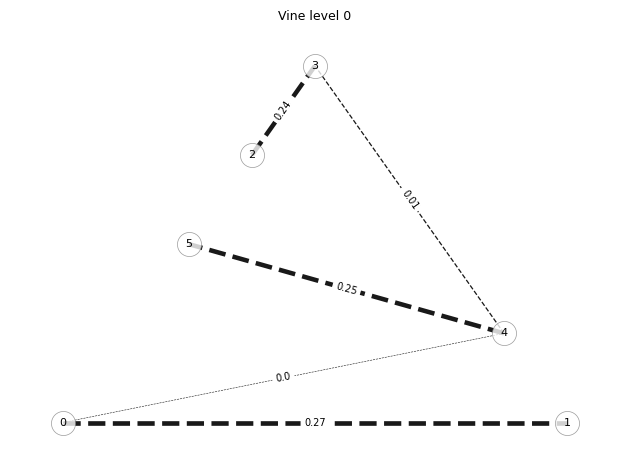

In [3]:
mdl_vcp.draw_lv(lv=0, is_bcp=True)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine comp graph'}>,
 <networkx.classes.digraph.DiGraph at 0x30237e210>)

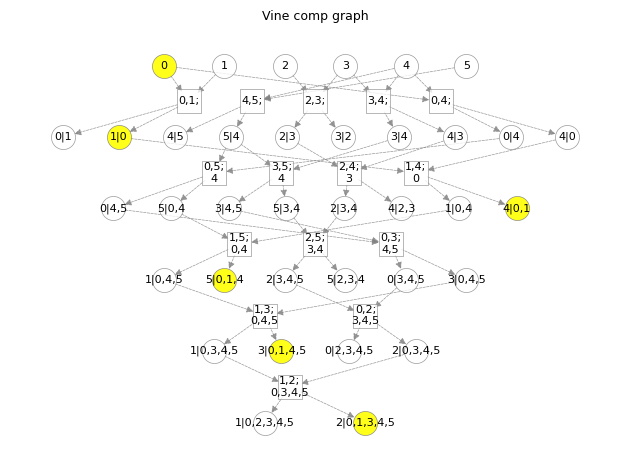

In [4]:
mdl_vcp.draw_dag()

## inside a VineCop obj

- $\frac{D(D-1)}{2}$ bicops (`torch.nn.Module` inside `ModuleDict`)
- parents of bicops
- parents of pseudo-obs
- a `staticmethod` oracle to query the number of h-function calls (and source vertices) given a sampling order on a vine


In [5]:
print(next(iter(mdl_vcp.marginals)))
print(next(iter(mdl_vcp.bicops.values())))

kdeCDFPPF1D
'num_obs': 10_000,
 'negloglik': 1.4249,
 'num_step_grid': 16_385,
 'dtype': torch.float64,
 'device': device(type='cpu')


BiCop
{'is_indep': False,
 'num_obs': tensor(10000, dtype=torch.int32),
 'negloglik': tensor(-4303.4462, dtype=torch.float64),
 'num_step_grid': 128,
 'tau': tensor([0., 0.], dtype=torch.float64),
 'dtype': torch.float64,
 'device': device(type='cpu')}


<Axes: title={'center': 'Estimated bivariate copula density'}, xlabel='$u_{left}$', ylabel='$u_{right}$'>

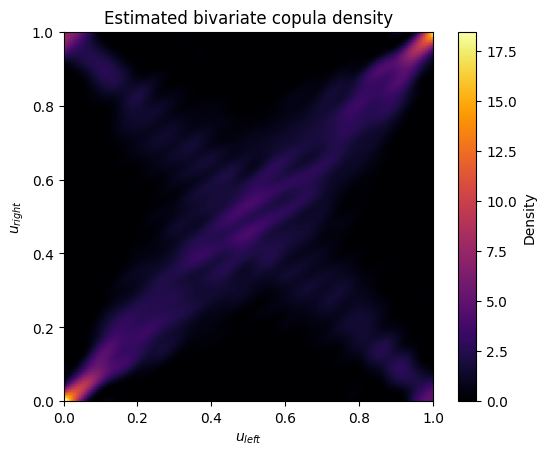

In [6]:
next(iter(mdl_vcp.bicops.values())).imshow()

In [7]:
print(mdl_vcp.bicops, mdl_vcp.struct_bcp, mdl_vcp.struct_obs)
mdl_vcp.ref_count_hfunc(
    num_dim=mdl_vcp.num_dim,
    struct_obs=mdl_vcp.struct_obs,
    sample_order=mdl_vcp.sample_order,
)

ModuleDict(
  (0,1): BiCop()
  (0,2): BiCop()
  (0,3): BiCop()
  (0,4): BiCop()
  (0,5): BiCop()
  (1,2): BiCop()
  (1,3): BiCop()
  (1,4): BiCop()
  (1,5): BiCop()
  (2,3): BiCop()
  (2,4): BiCop()
  (2,5): BiCop()
  (3,4): BiCop()
  (3,5): BiCop()
  (4,5): BiCop()
) {'0,1': {'cond_ed': (0, 1), 'cond_ing': (), 'is_indep': False, 'left': '', 'right': ''}, '0,2': {'cond_ed': (0, 2), 'cond_ing': (3, 4, 5), 'is_indep': True, 'left': '0,3', 'right': '2,5'}, '0,3': {'cond_ed': (0, 3), 'cond_ing': (4, 5), 'is_indep': True, 'left': '0,5', 'right': '3,5'}, '0,4': {'cond_ed': (0, 4), 'cond_ing': (), 'is_indep': True, 'left': '', 'right': ''}, '0,5': {'cond_ed': (0, 5), 'cond_ing': (4,), 'is_indep': True, 'left': '0,4', 'right': '4,5'}, '1,2': {'cond_ed': (1, 2), 'cond_ing': (0, 3, 4, 5), 'is_indep': True, 'left': '1,3', 'right': '0,2'}, '1,3': {'cond_ed': (1, 3), 'cond_ing': (0, 4, 5), 'is_indep': True, 'left': '1,5', 'right': '0,3'}, '1,4': {'cond_ed': (1, 4), 'cond_ing': (0,), 'is_indep': Tru

({(0,): 4,
  (1,): 1,
  (1, 0): 3,
  (4, 0): 3,
  (4, 0, 1): 1,
  (4,): 5,
  (1, 0, 4): 3,
  (5, 0, 4): 3,
  (5, 0, 1, 4): 1,
  (0, 4): 3,
  (5, 4): 5,
  (5,): 1,
  (1, 0, 4, 5): 3,
  (3, 0, 4, 5): 3,
  (3, 0, 1, 4, 5): 1,
  (0, 4, 5): 3,
  (3, 4, 5): 3,
  (3, 4): 3,
  (3,): 3,
  (1, 0, 3, 4, 5): 2,
  (2, 0, 3, 4, 5): 2,
  (2, 0, 1, 3, 4, 5): 1,
  (0, 3, 4, 5): 2,
  (2, 3, 4, 5): 2,
  (5, 3, 4): 2,
  (2, 3, 4): 2,
  (4, 3): 2,
  (2, 3): 2,
  (2,): 1},
 [(0,), (1, 0), (4, 0, 1), (5, 0, 1, 4), (3, 0, 1, 4, 5), (2, 0, 1, 3, 4, 5)],
 8)

## log_pdf, cdf


In [8]:
mdl_vcp.log_pdf(obs=obs)[:5]

tensor([[ -7.4439],
        [-12.5866],
        [ -7.3967],
        [ -5.7195],
        [ -7.0609]], dtype=torch.float64)

In [15]:
mdl_vcp.cdf(obs=obs)[:5]

tensor([[0.1070],
        [0.2382],
        [0.0965],
        [0.0826],
        [0.1048]], dtype=torch.float64)

# (conditional) sampling

- default sampling given $0$ columns of observations
- quantile regression given $D-1$ columns of observations
- conditional simulation otherwise


In [14]:
mdl_vcp.sample()[:5]

tensor([[-1.5613, -1.9731, -0.0094,  0.0577, -1.1378, -1.5542],
        [ 1.6916,  2.2960, -0.9239, -1.0102, -1.3549, -1.5993],
        [ 1.0130,  1.2861,  0.9960, -1.3466, -0.3021, -0.0061],
        [ 0.3228,  0.1139, -0.5078, -0.4993, -1.4124,  0.4798],
        [-1.8462, -3.6556, -0.9126, -0.6371,  1.5084, -1.4376]],
       dtype=torch.float64)

In [11]:
mdl_vcp.sample_order

(2, 3, 5, 4, 1, 0)

In [12]:
mdl_vcp.sample(
    num_sample=1000,
    is_sobol=True,
    sample_order=mdl_vcp.sample_order[:-2],
    dct_v_s_obs={
        (mdl_vcp.sample_order[-1],): torch.ones(size=(1000, 1), device=mdl_vcp._dd.device),
        (mdl_vcp.sample_order[-2],): torch.zeros(size=(1000, 1), device=mdl_vcp._dd.device),
    },
)[:5]

tensor([[ 1.0000e+00,  7.0019e-17,  4.7590e-01,  9.2777e-01,  3.0735e+00,
         -2.3657e+00],
        [ 1.0000e+00,  7.0019e-17, -1.0530e+00, -1.4429e+00, -1.0769e-01,
          3.0464e-01],
        [ 1.0000e+00,  7.0019e-17, -4.8854e-01,  5.1517e-01, -7.6652e-01,
         -7.7179e-01],
        [ 1.0000e+00,  7.0019e-17,  3.1751e-01, -1.3916e-01,  6.3542e-01,
          4.0857e-01],
        [ 1.0000e+00,  7.0019e-17,  1.1699e+00, -1.0190e+00,  2.3168e-01,
         -2.8503e-02]], dtype=torch.float64)

## monotonicity test

- `cdf` non decreasing in 1D (fix others) and "diagonal" directions


In [13]:
grid_Zd = (
    ndtri(torch.linspace(_EPS, 1 - _EPS, 100).reshape(-1, 1).repeat(1, num_dim))
    .to(DEVICE, dtype=torch.float64)
    .nan_to_num()
)
vec = mdl_vcp.cdf(grid_Zd)
assert 0 <= vec.min() and vec.max() <= 1
assert vec.diff(dim=0).min() >= 0
grid_Z = (
    ndtri(torch.linspace(_EPS, 1 - _EPS, 100).reshape(-1, 1))
    .to(DEVICE, dtype=torch.float64)
    .nan_to_num()
)
for i in torch.linspace(_EPS, 1 - _EPS, 20):
    grid_Zd = torch.hstack(
        [
            grid_Z.repeat(1, num_dim - 1),
            torch.full(
                size=(grid_Z.shape[0], 1),
                fill_value=i,
                device=DEVICE,
                dtype=grid_Z.dtype,
            ),
        ]
    )
    for d in range(num_dim):
        vec = mdl_vcp.cdf(grid_Zd.roll(d, dims=1))
        assert 0 <= vec.min() and vec.max() <= 1
        assert vec.diff(dim=0).min() >= 0